## Importando bibliotecas e preparando o ambiente Spark

In [3]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.7


In [101]:
# Imports
import pyspark
import pandas
import matplotlib.pyplot as plt
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import * 
from pyspark.sql.functions import *

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy    : 1.22.3
decimal  : 1.70
sys      : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
findspark: 2.0.1
pyspark  : 3.5.0
pandas   : 1.3.4



In [6]:
# Criando o Spark Context
sc = SparkContext(appName = "Projeto03")

In [7]:
sc.setLogLevel("ERROR")

In [8]:
# Criando a sessão
spark = SparkSession.builder.getOrCreate()

In [9]:
spark

## Análise Exploratória dos Dados ("EDA")

In [10]:
# Carrega os dados
dados = pandas.read_excel('TFL Bus Safety.xlsx')

In [11]:
type(dados)

pandas.core.frame.DataFrame

In [12]:
# Tamanho de linhas e colunas
dados.shape

(23158, 12)

In [13]:
# Tipos de dados
dados.dtypes

Year                                  int64
Date Of Incident             datetime64[ns]
Route                                object
Operator                             object
Group Name                           object
Bus Garage                           object
Borough                              object
Injury Result Description            object
Incident Event Type                  object
Victim Category                      object
Victims Sex                          object
Victims Age                          object
dtype: object

In [14]:
# Visualiza as 5 primeiras linhas do dataframe
dados.head()

,Year,Date Of Incident,Route,Operator,Group Name,Bus Garage,Borough,Injury Result Description,Incident Event Type,Victim Category,Victims Sex,Victims Age
0,2015,2015-01-01,1,London General,Go-Ahead,Garage Not Available,Southwark,Injuries treated on scene,Onboard Injuries,Passenger,Male,Child
1,2015,2015-01-01,4,Metroline,Metroline,Garage Not Available,Islington,Injuries treated on scene,Onboard Injuries,Passenger,Male,Unknown
2,2015,2015-01-01,5,East London,Stagecoach,Garage Not Available,Havering,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly
3,2015,2015-01-01,5,East London,Stagecoach,Garage Not Available,None London Borough,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly
4,2015,2015-01-01,6,Metroline,Metroline,Garage Not Available,Westminster,Reported Minor Injury - Treated at Hospital,Onboard Injuries,Pedestrian,Female,Elderly


In [15]:
# Resumo das variáveis com pouca variação de registros

cols_de_interesse = ["Year", "Injury Result Description", "Incident Event Type", 
                       "Victim Category", "Victims Sex", "Victims Age"]

for col in cols_de_interesse:
    unique_values = dados[col].value_counts()
    print(f"Valores únicos na coluna '{col}': {unique_values}")
    print()

Valores únicos na coluna 'Year': 2017    6573
2016    6093
2015    5715
2018    4777
Name: Year, dtype: int64

Valores únicos na coluna 'Injury Result Description': Injuries treated on scene                                          17336
Taken to Hospital – Reported Serious Injury or Severity Unknown     2994
Reported Minor Injury - Treated at Hospital                         2786
Fatal                                                                 42
Name: Injury Result Description, dtype: int64

Valores únicos na coluna 'Incident Event Type': Slip Trip Fall             6981
Onboard Injuries           6563
Personal Injury            4596
Collision Incident         4166
Assault                     590
Activity Incident Event     114
Vandalism Hooliganism        73
Safety Critical Failure      66
Fire                          6
Robbery                       3
Name: Incident Event Type, dtype: int64

Valores únicos na coluna 'Victim Category': Passenger                      18828
Pedest

## Convertendo Dataframe do Pandas em Dataframe do Spark

In [16]:
# Converte Dataframe do Pandas em Dataframe do Spark
df_spark = spark.createDataFrame(dados)

In [17]:
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [18]:
df_spark.printSchema()

root
 |-- Year: long (nullable = true)
 |-- Date Of Incident: timestamp (nullable = true)
 |-- Route: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Group Name: string (nullable = true)
 |-- Bus Garage: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Injury Result Description: string (nullable = true)
 |-- Incident Event Type: string (nullable = true)
 |-- Victim Category: string (nullable = true)
 |-- Victims Sex: string (nullable = true)
 |-- Victims Age: string (nullable = true)



In [19]:
df_spark.show

<bound method DataFrame.show of DataFrame[Year: bigint, Date Of Incident: timestamp, Route: string, Operator: string, Group Name: string, Bus Garage: string, Borough: string, Injury Result Description: string, Incident Event Type: string, Victim Category: string, Victims Sex: string, Victims Age: string]>

## Queries SQL para responder as perguntas

In [20]:
# Cria tabela temporária
df_spark.createOrReplaceTempView("TFL_Bus_Safety")

In [21]:
# Verificando as colunas da tabela
spark.sql("SHOW COLUMNS FROM TFL_Bus_Safety").show()

+--------------------+
|            col_name|
+--------------------+
|                Year|
|    Date Of Incident|
|               Route|
|            Operator|
|          Group Name|
|          Bus Garage|
|             Borough|
|Injury Result Des...|
| Incident Event Type|
|     Victim Category|
|         Victims Sex|
|         Victims Age|
+--------------------+



In [22]:
# 1- Qual a quantidade de incidentes por gênero?
spark.sql("""
SELECT `Victims Sex`, COUNT(*) AS Quantidade 
FROM TFL_Bus_Safety 
GROUP BY `Victims Sex`
""").show()

+-----------+----------+
|Victims Sex|Quantidade|
+-----------+----------+
|     Female|     11847|
|    Unknown|      3602|
|       Male|      7709|
+-----------+----------+



In [23]:
# 2- Qual faixa etária esteve mais envolvida nos incidentes?
spark.sql("""
SELECT `Victims Age`, COUNT(*) AS Quantidade 
FROM TFL_Bus_Safety 
GROUP BY `Victims Age`
ORDER BY Quantidade DESC
""").show()

# RESPOSTA: Adult

+-----------+----------+
|Victims Age|Quantidade|
+-----------+----------+
|      Adult|     10754|
|    Unknown|      7135|
|    Elderly|      2769|
|      Child|      2181|
|      Youth|       319|
+-----------+----------+



In [24]:
# 3- Qual o percentual de incidentes por tipo de evento (Incident Event Type)?
spark.sql("""
WITH TOTAL AS (SELECT COUNT(*) AS total FROM TFL_Bus_Safety)

SELECT 
    `Incident Event Type`, 
    COUNT(*) AS Quantidade,
    ROUND(COUNT(*) / (SELECT total FROM TOTAL) * 100, 2) AS Percentual
FROM 
    TFL_Bus_Safety 
GROUP BY 
    `Incident Event Type`
ORDER BY 
    Quantidade DESC;
""").show()

+--------------------+----------+----------+
| Incident Event Type|Quantidade|Percentual|
+--------------------+----------+----------+
|      Slip Trip Fall|      6981|     30.15|
|    Onboard Injuries|      6563|     28.34|
|     Personal Injury|      4596|     19.85|
|  Collision Incident|      4166|     17.99|
|             Assault|       590|      2.55|
|Activity Incident...|       114|      0.49|
|Vandalism Hooliga...|        73|      0.32|
|Safety Critical F...|        66|      0.28|
|                Fire|         6|      0.03|
|             Robbery|         3|      0.01|
+--------------------+----------+----------+



In [31]:
# 4- Como foi a evolução de incidentes por mês ao longo do tempo?
spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'yyyy-MM') AS AnoMes,
    COUNT(*) AS Quantidade 
FROM 
    TFL_Bus_Safety 
GROUP BY 
    AnoMes
ORDER BY 
    AnoMes;

""").show()

+-------+----------+
| AnoMes|Quantidade|
+-------+----------+
|2015-01|       399|
|2015-02|       371|
|2015-03|       460|
|2015-04|       470|
|2015-05|       472|
|2015-06|       564|
|2015-07|       558|
|2015-08|       446|
|2015-09|       487|
|2015-10|       470|
|2015-11|       495|
|2015-12|       523|
|2016-01|       466|
|2016-02|       484|
|2016-03|       449|
|2016-04|       504|
|2016-05|       494|
|2016-06|       460|
|2016-07|       507|
|2016-08|       513|
+-------+----------+
only showing top 20 rows



In [50]:
# 5- Quando o incidente foi “Collision Incident” em qual mês houve o maior número de incidentes envolvendo 
    # pessoas do sexo feminino?
spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'MM') AS Mes,
    COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    `Incident Event Type` = "Collision Incident"
    AND `Victims Sex` = "Female"
GROUP BY 
    Mes
ORDER BY 
    Mes

""").show()

# RESPOSTA: No mês 09 com 158 acidentes

+---+----------+
|Mes|Quantidade|
+---+----------+
| 01|       137|
| 02|       116|
| 03|       129|
| 04|       147|
| 05|       123|
| 06|       150|
| 07|       147|
| 08|       122|
| 09|       158|
| 10|       113|
| 11|       140|
| 12|        76|
+---+----------+



In [59]:
# 6- Qual foi a média de incidentes por mês envolvendo crianças (Child)?

spark.sql("""
WITH AUX AS (
    SELECT COUNT(*) AS Quantidade, `Date Of Incident`
    FROM 
        TFL_Bus_Safety
    WHERE
        `Victims Age` = "Child"
    GROUP BY 
        `Date Of Incident`)
        
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'MM') AS Mes, 
    ROUND(AVG(Quantidade), 1) AS `Média de Incidentes`
FROM 
    AUX
GROUP BY
    Mes
ORDER BY
    Mes 
""").show()

+---+-------------------+
|Mes|Média de Incidentes|
+---+-------------------+
| 01|               31.5|
| 02|               36.5|
| 03|               47.5|
| 04|               56.5|
| 05|               51.5|
| 06|               61.3|
| 07|               58.0|
| 08|               52.0|
| 09|               56.3|
| 10|               50.0|
| 11|               40.0|
| 12|               35.7|
+---+-------------------+



In [60]:
# 7- Considerando a descrição de incidente como “Injuries treated on scene” (coluna Injury Result Description), 
    # qual o total de incidentes de pessoas do sexo masculino e sexo feminino?

spark.sql("""
SELECT 
    `Victims Sex`, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    `Victims Sex` = "Female" OR `Victims Sex` = "Male"
    AND `Injury Result Description` = "Injuries treated on scene"
GROUP BY
    `Victims Sex`
""").show()

+-----------+----------+
|Victims Sex|Quantidade|
+-----------+----------+
|     Female|     11847|
|       Male|      5632|
+-----------+----------+



In [65]:
# 8- No ano de 2017 em qual mês houve mais incidentes com idosos (Elderly)?

spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'yyyy-MM') AS AnoMes, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    YEAR(`Date Of Incident`) = 2017
    AND `Victims Age` = "Elderly"
GROUP BY
    AnoMes
ORDER BY
    AnoMes
""").show()

# RESPOSTA: No mês 07 com 81 acidentes

+-------+----------+
| AnoMes|Quantidade|
+-------+----------+
|2017-01|        66|
|2017-02|        53|
|2017-03|        77|
|2017-04|        75|
|2017-05|        69|
|2017-06|        65|
|2017-07|        81|
|2017-08|        70|
|2017-09|        78|
|2017-10|        69|
|2017-11|        68|
|2017-12|        67|
+-------+----------+



In [71]:
# 9- Considerando o Operador qual a distribuição de incidentes ao longo do tempo?

spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'yyyy') AS Ano, Operator, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
GROUP BY
    Operator, Ano 
ORDER BY
    Operator, Ano
""").show()

+----+--------------------+----------+
| Ano|            Operator|Quantidade|
+----+--------------------+----------+
|2015|      Abellio London|       117|
|2016|      Abellio London|       233|
|2017|      Abellio London|       329|
|2018|      Abellio London|       284|
|2015|        Abellio West|        27|
|2016|        Abellio West|        34|
|2017|        Abellio West|        50|
|2018|        Abellio West|        15|
|2015|Arriva Kent Thame...|        73|
|2016|Arriva Kent Thame...|        34|
|2015| Arriva London North|       789|
|2016| Arriva London North|       656|
|2017| Arriva London North|      1026|
|2018| Arriva London North|       737|
|2015| Arriva London South|       482|
|2016| Arriva London South|       429|
|2017| Arriva London South|       470|
|2018| Arriva London South|       362|
|2015|   Arriva The Shires|       126|
|2016|   Arriva The Shires|       107|
+----+--------------------+----------+
only showing top 20 rows



In [74]:
# 10- Qual o tipo de incidente mais comum com ciclistas?

spark.sql("""
SELECT 
    `Incident Event Type`, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    `Victim Category` = "Cyclist"
GROUP BY
    `Incident Event Type` 
ORDER BY
    `Incident Event Type`
""").show()

# RESPOSTA: Collision Incident

+-------------------+----------+
|Incident Event Type|Quantidade|
+-------------------+----------+
| Collision Incident|       256|
|   Onboard Injuries|         4|
|    Personal Injury|         8|
|     Slip Trip Fall|         7|
+-------------------+----------+



## Gráficos a partir das queries em SQL para melhor visualização

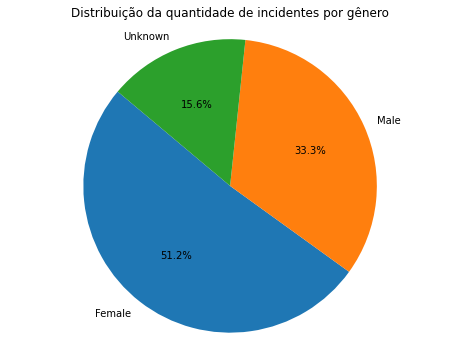

In [92]:
# 1- Qual a quantidade de incidentes por gênero?

    # -> Optou-se por trazer a categoria Unknown para se ter uma visão completa dos dados

Q1 = spark.sql("""
SELECT `Victims Sex`, COUNT(*) AS Quantidade 
FROM TFL_Bus_Safety 
GROUP BY `Victims Sex`
ORDER BY Quantidade DESC
""")
Q1_pd = Q1.toPandas()

# Extrair os dados do DataFrame Pandas
sexo = Q1_pd['Victims Sex']
quantidade = Q1_pd['Quantidade']

# Criar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(quantidade, labels=sexo, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição da quantidade de incidentes por gênero')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

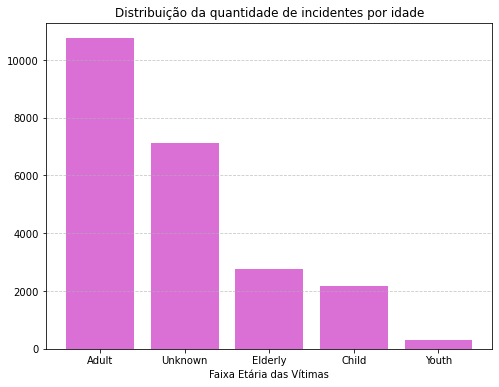

In [84]:
# 2- Qual faixa etária esteve mais envolvida nos incidentes?

    # -> Optou-se por trazer a categoria Unknown para se ter uma visão completa dos dados
    
Q2 = spark.sql("""
SELECT `Victims Age`, COUNT(*) AS Quantidade 
FROM TFL_Bus_Safety 
GROUP BY `Victims Age`
ORDER BY Quantidade DESC
""")

Q2_pd = Q2.toPandas()

# Extrair os dados do DataFrame Pandas
idade = Q2_pd['Victims Age']
quantidade = Q2_pd['Quantidade']

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(idade, quantidade, color='orchid')
plt.title('Distribuição da quantidade de incidentes por idade')
plt.xlabel('Faixa Etária das Vítimas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

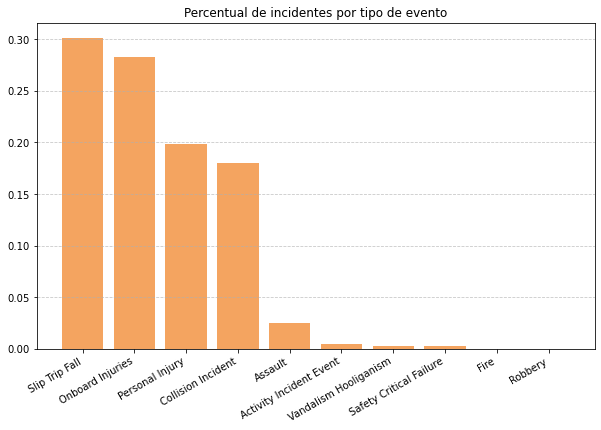

In [98]:
# 3- Qual o percentual de incidentes por tipo de evento (Incident Event Type)?
Q3 = spark.sql("""
WITH TOTAL AS (SELECT COUNT(*) AS total FROM TFL_Bus_Safety)

SELECT 
    `Incident Event Type`, 
    ROUND(COUNT(*) / (SELECT total FROM TOTAL), 3) AS Percentual
FROM 
    TFL_Bus_Safety 
GROUP BY 
    `Incident Event Type`
ORDER BY 
    Percentual DESC;
""")

Q3_pd = Q3.toPandas()

# Extrair os dados do DataFrame Pandas
evento = Q3_pd['Incident Event Type']
percentual = Q3_pd['Percentual']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(evento, percentual, color='sandybrown')
plt.title('Percentual de incidentes por tipo de evento')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

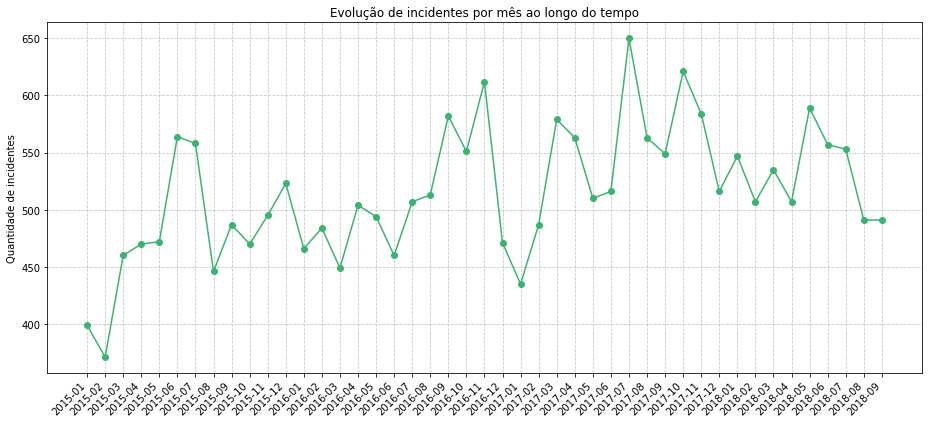

In [100]:
# 4- Como foi a evolução de incidentes por mês ao longo do tempo?

# -> Ao longo do tempo foi interpretado como considerar todos os anos

Q4 = spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'yyyy-MM') AS AnoMes,
    COUNT(*) AS Quantidade 
FROM 
    TFL_Bus_Safety 
GROUP BY 
    AnoMes
ORDER BY 
    AnoMes;
""")

Q4_pd = Q4.toPandas()

# Extrair os dados do DataFrame Pandas
meses = Q4_pd['AnoMes']
quantidade = Q4_pd['Quantidade']

# Criar o gráfico de barras
plt.figure(figsize=(13, 6))
plt.plot(meses, quantidade, marker='o', color='mediumseagreen', linestyle='-')
plt.title('Evolução de incidentes por mês ao longo do tempo')
plt.ylabel('Quantidade de incidentes')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

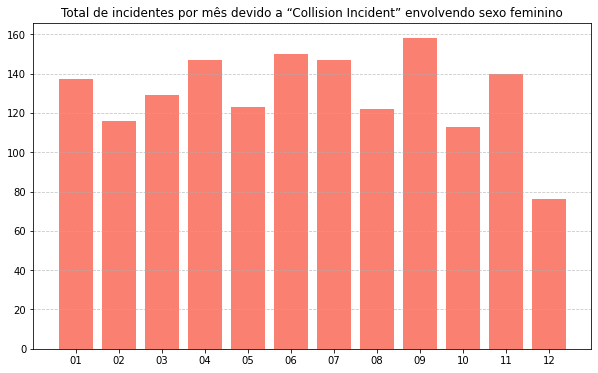

In [118]:
# 5- Quando o incidente foi “Collision Incident” em qual mês houve o maior número de incidentes envolvendo 
    # pessoas do sexo feminino?
    
    #-> "Em qual mês" foi interpretado como um agrupamento por mês para todos os anos, e não para cada ano separadamente
    
Q5 = spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'MM') AS Mes,
    COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    `Incident Event Type` = "Collision Incident"
    AND `Victims Sex` = "Female"
GROUP BY 
    Mes
ORDER BY 
    Mes
""")

Q5_pd = Q5.toPandas()

# Extrair os dados do DataFrame Pandas
meses = Q5_pd['Mes']
quantidade = Q5_pd['Quantidade']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(meses, quantidade, color='salmon')
plt.title('Total de incidentes por mês devido a “Collision Incident” envolvendo sexo feminino')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

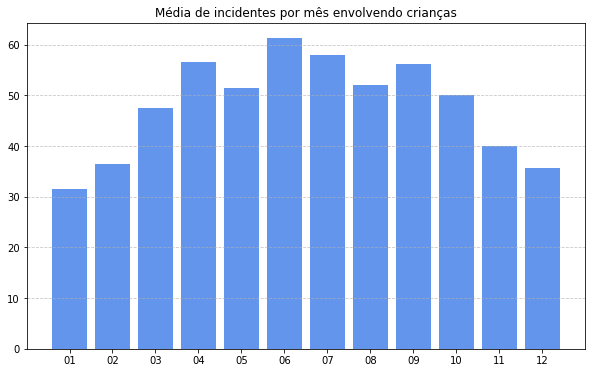

In [117]:
# 6- Qual foi a média de incidentes por mês envolvendo crianças (Child)?

    # -> Novamente, a "média por mês" foi interpretada como o agrupamento por mês de todos os anos

Q6 = spark.sql("""
WITH AUX AS (
    SELECT COUNT(*) AS Quantidade, `Date Of Incident`
    FROM 
        TFL_Bus_Safety
    WHERE
        `Victims Age` = "Child"
    GROUP BY 
        `Date Of Incident`)
        
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'MM') AS Mes, 
    ROUND(AVG(Quantidade), 1) AS `Média de Incidentes`
FROM 
    AUX
GROUP BY
    Mes
ORDER BY
    Mes 
""")

Q6_pd = Q6.toPandas()

# Extrair os dados do DataFrame Pandas
meses = Q6_pd['Mes']
quantidade = Q6_pd['Média de Incidentes']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(meses, quantidade, color='cornflowerblue')
plt.title('Média de incidentes por mês envolvendo crianças')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

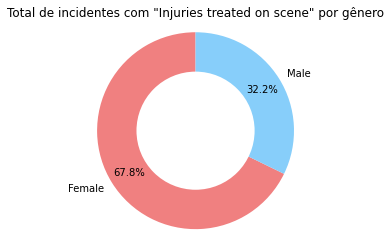

In [122]:
# 7- Considerando a descrição de incidente como “Injuries treated on scene” (coluna Injury Result Description), 
    # qual o total de incidentes de pessoas do sexo masculino e sexo feminino?

Q7 = spark.sql("""
SELECT 
    `Victims Sex`, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    `Victims Sex` = "Female" OR `Victims Sex` = "Male"
    AND `Injury Result Description` = "Injuries treated on scene"
GROUP BY
    `Victims Sex`
""")

Q7_pd = Q7.toPandas()

# Extrair os dados do DataFrame Pandas
sexo = Q7_pd['Victims Sex']
quantidade = Q7_pd['Quantidade']

# Dados
labels = ['Female', 'Male']
sizes = quantidade
colors = ['lightcoral', 'lightskyblue']

# Círculo exterior
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.8)

# Círculo interior branco 
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect
ax.axis('equal')  

plt.title('Total de incidentes com "Injuries treated on scene" por gênero')

plt.show()

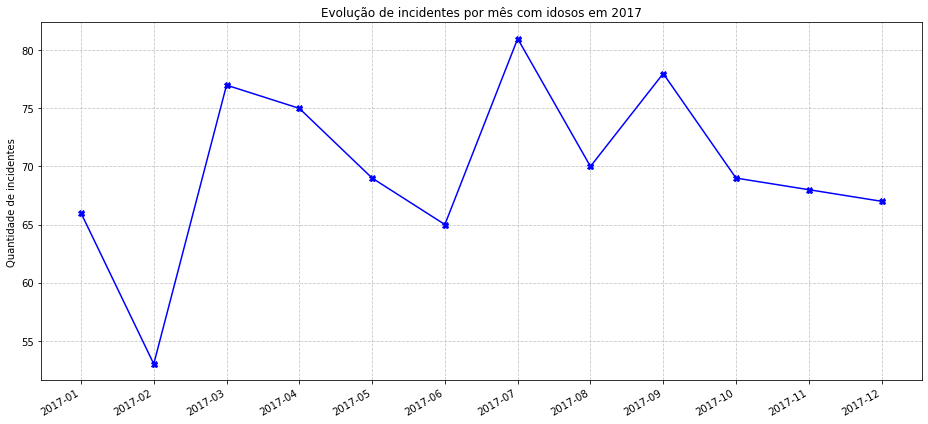

In [126]:
# 8- No ano de 2017 em qual mês houve mais incidentes com idosos (Elderly)?

Q8 = spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'yyyy-MM') AS AnoMes, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    YEAR(`Date Of Incident`) = 2017
    AND `Victims Age` = "Elderly"
GROUP BY
    AnoMes
ORDER BY
    AnoMes
""")

Q8_pd = Q8.toPandas()

# Extrair os dados do DataFrame Pandas
meses = Q8_pd['AnoMes']
quantidade = Q8_pd['Quantidade']

# Criar o gráfico de barras
plt.figure(figsize=(13, 6))
plt.plot(meses, quantidade, marker='X', color='blue', linestyle='-')
plt.title('Evolução de incidentes por mês com idosos em 2017')
plt.ylabel('Quantidade de incidentes')
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

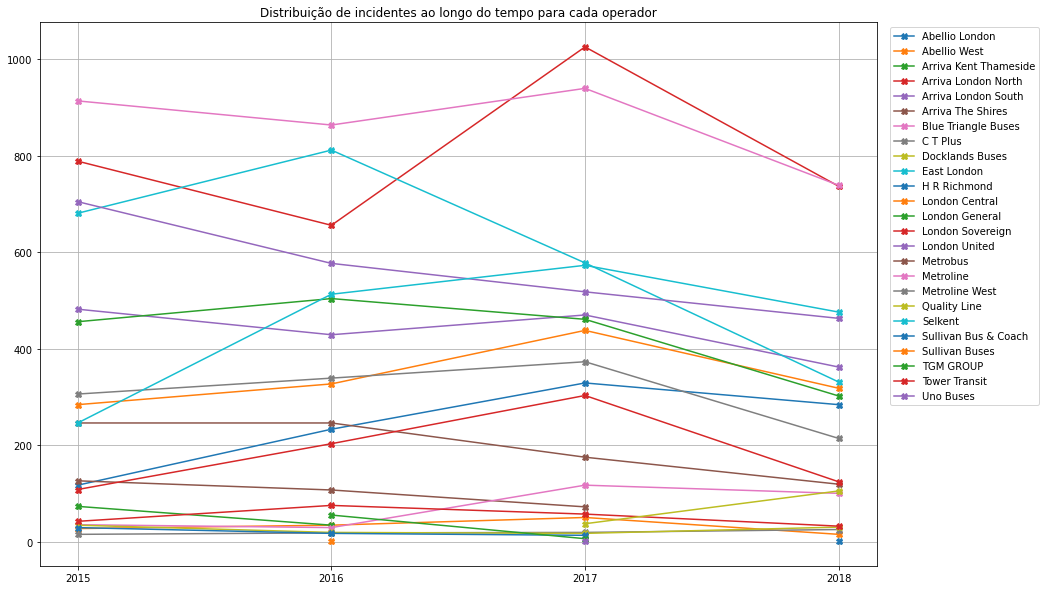

In [136]:
# 9- Considerando o Operador qual a distribuição de incidentes ao longo do tempo?

# -> Aqui optei pelo agrupamento por ano para não ficar muito poluido de informações caso fosse mensal, e ainda podemos
    # visualizar as evoluçoes ao longo do tempo

Q9 = spark.sql("""
SELECT 
    DATE_FORMAT(`Date Of Incident`, 'yyyy') AS Ano, Operator, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
GROUP BY
    Operator, Ano 
ORDER BY
    Operator, Ano
""")

Q9_pd = Q9.toPandas()

# Operators distintos
operators = Q9_pd['Operator'].unique()

# Plot gráfico de linhas para cada operator
plt.figure(figsize=(15, 10))

for operator in operators:
    data = Q9_pd[Q9_pd['Operator'] == operator]
    plt.plot(data['Ano'], data['Quantidade'], marker='X', label=operator)

plt.title('Distribuição de incidentes ao longo do tempo para cada operador')
plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.show()

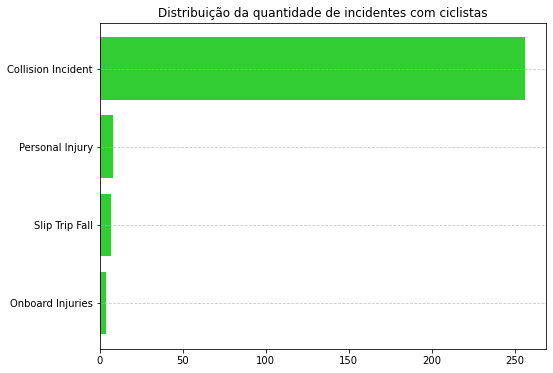

In [141]:
# 10- Qual o tipo de incidente mais comum com ciclistas?

Q10 = spark.sql("""
SELECT 
    `Incident Event Type`, COUNT(*) AS Quantidade
FROM 
    TFL_Bus_Safety
WHERE
    `Victim Category` = "Cyclist"
GROUP BY
    `Incident Event Type` 
ORDER BY
    `Quantidade`
""")

Q10_pd = Q10.toPandas()

# Extrair os dados do DataFrame Pandas
incidente = Q10_pd['Incident Event Type']
quantidade = Q10_pd['Quantidade']

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
plt.barh(incidente, quantidade, color='limegreen')
plt.title('Distribuição da quantidade de incidentes com ciclistas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()